# Proposal 2

$$
\mathcal{L} = \mathcal{L}_c + \lambda_1 || \bm{s} \odot \bm{\theta} ||_1 + \lambda_2 || (\bm{1 - s}) \odot \bm{\theta}||_2^2
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
import pandas as pd
import plotly.express as px
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.training import CTSV1
from base_code.plugins import WeightStoragePlugin

# Device

In [5]:
from torch import cuda
device = "cuda" if cuda.is_available() else "cpu"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(10, seed=1234, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [16]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=device),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [17]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [18]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(device)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss().to(device)
strategy = CTSV1(
    model,
    optimizer,
    criterion,
    lambda_l1=1.0, lambda_l2=1e-2, eps=1e-5,
    train_epochs=5, train_mb_size=128, eval_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    device=device
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 105.36it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 133.0000
	Loss_MB/train_phase/train_stream/Task000 = 11.3384
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.4521
100%|██████████| 469/469 [00:04<00:00, 105.85it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 123.8000
	Loss_MB/train_phase/train_stream/Task000 = 9.6851
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.4314
100%|██████████| 469/469 [00:04<00:00, 104.06it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 124.4000
	Loss_MB/train_phase/train_stream/Task000 = 8.6653
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.5072
100%|██████████| 469/469 [00:04<00:00, 104.01it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 103.1120
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x167dbde80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   


-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.1849
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x167f82220>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
  

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.8741
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x168c93430>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.5681, 0.7682, 0.7833, 0.1386, 0.1280, 0.1178, 0.1518, 0.1408, 0.1375,
         0.1364],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.2558
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x168e3fdf0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.5681, 0.7682, 0.7833, 0.1386, 0.1280, 0.1178, 0.1518, 0.1408, 0.1375,
         0.1364],
        [0.4992, 0.7485, 0.7879, 0.8014, 0.1097, 0.0842, 0.1780, 0.1943, 0.0959,
         0.0958],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.1724
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x169356be0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.5681, 0.7682, 0.7833, 0.1386, 0.1280, 0.1178, 0.1518, 0.1408, 0.1375,
         0.1364],
        [0.4992, 0.7485, 0.7879, 0.8014, 0.1097, 0.0842, 0.1780, 0.1943, 0.0959,
         0.0958],
        [0.5028, 0.7421, 0.7696, 0.7790, 0.8168, 0.0842, 0.1298, 0.1716, 0.1412,
         0.1172],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.0431
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x168afb520>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.5681, 0.7682, 0.7833, 0.1386, 0.1280, 0.1178, 0.1518, 0.1408, 0.1375,
         0.1364],
        [0.4992, 0.7485, 0.7879, 0.8014, 0.1097, 0.0842, 0.1780, 0.1943, 0.0959,
         0.0958],
        [0.5028, 0.7421, 0.7696, 0.7790, 0.8168, 0.0842, 0.1298, 0.1716, 0.1412,
         0.1172],
        [0.4399, 0.7180, 0.7566, 0.7835, 0.8112, 0.8296, 0.1309, 0.2061, 0.1495,
         0.1035],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.0938
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x169b60490>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.5681, 0.7682, 0.7833, 0.1386, 0.1280, 0.1178, 0.1518, 0.1408, 0.1375,
         0.1364],
        [0.4992, 0.7485, 0.7879, 0.8014, 0.1097, 0.0842, 0.1780, 0.1943, 0.0959,
         0.0958],
        [0.5028, 0.7421, 0.7696, 0.7790, 0.8168, 0.0842, 0.1298, 0.1716, 0.1412,
         0.1172],
        [0.4399, 0.7180, 0.7566, 0.7835, 0.8112, 0.8296, 0.1309, 0.2061, 0.1495,
         0.1035],
        [0.4196, 0.7018, 0.6844, 0.7469, 0.7878, 0.8048, 0.8335, 0.1670, 0.1403,
         0.0938],
   

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6759
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1699be880>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.5681, 0.7682, 0.7833, 0.1386, 0.1280, 0.1178, 0.1518, 0.1408, 0.1375,
         0.1364],
        [0.4992, 0.7485, 0.7879, 0.8014, 0.1097, 0.0842, 0.1780, 0.1943, 0.0959,
         0.0958],
        [0.5028, 0.7421, 0.7696, 0.7790, 0.8168, 0.0842, 0.1298, 0.1716, 0.1412,
         0.1172],
        [0.4399, 0.7180, 0.7566, 0.7835, 0.8112, 0.8296, 0.1309, 0.2061, 0.1495,
         0.1035],
        [0.4196, 0.7018, 0.6844, 0.7469, 0.7878, 0.8048, 0.8335, 0.1670, 0.1403,
         0.0938],
   

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.0278
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16a1b12e0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.5681, 0.7682, 0.7833, 0.1386, 0.1280, 0.1178, 0.1518, 0.1408, 0.1375,
         0.1364],
        [0.4992, 0.7485, 0.7879, 0.8014, 0.1097, 0.0842, 0.1780, 0.1943, 0.0959,
         0.0958],
        [0.5028, 0.7421, 0.7696, 0.7790, 0.8168, 0.0842, 0.1298, 0.1716, 0.1412,
         0.1172],
        [0.4399, 0.7180, 0.7566, 0.7835, 0.8112, 0.8296, 0.1309, 0.2061, 0.1495,
         0.1035],
        [0.4196, 0.7018, 0.6844, 0.7469, 0.7878, 0.8048, 0.8335, 0.1670, 0.1403,
         0.0938],
   

100%|██████████| 10/10 [05:13<00:00, 31.33s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.5124
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1740aad60>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 14186.2734
	EvalStream/Acc_Matrix = 
tensor([[0.7231, 0.1560, 0.1806, 0.1693, 0.0967, 0.1287, 0.1471, 0.1558, 0.1649,
         0.1632],
        [0.6331, 0.7808, 0.1984, 0.2087, 0.1821, 0.1147, 0.2154, 0.1321, 0.1607,
         0.1939],
        [0.5681, 0.7682, 0.7833, 0.1386, 0.1280, 0.1178, 0.1518, 0.1408, 0.1375,
         0.1364],
        [0.4992, 0.7485, 0.7879, 0.8014, 0.1097, 0.0842, 0.1780, 0.1943, 0.0959,
         0.0958],
        [0.5028, 0.7421, 0.7696, 0.7790, 0.8168, 0.0842, 0.1298, 0.1716, 0.1412,
         0.1172],
        [0.4399, 0.7180, 0.7566, 0.7835, 0.8112, 0.8296, 0.1309, 0.2061, 0.1495,
         0.1035],
        [0.4196, 0.7018, 0.6844, 0.7469, 0.7878, 0.8048, 0.8335, 0.1670, 0.1403,
         0.0938],
   

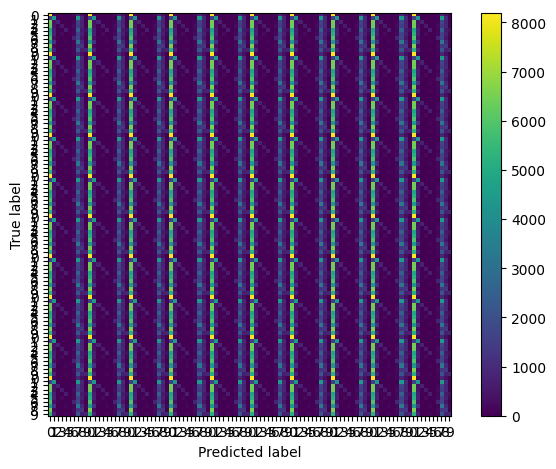

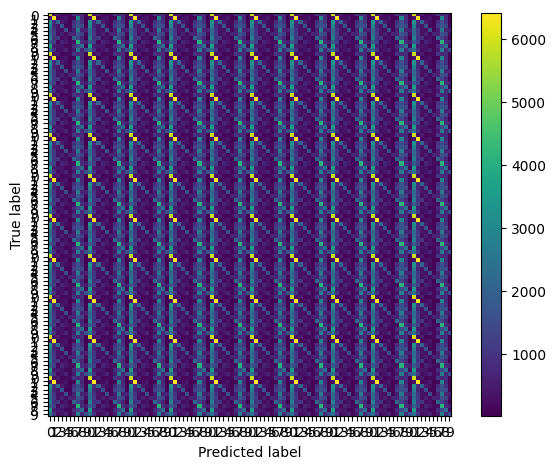

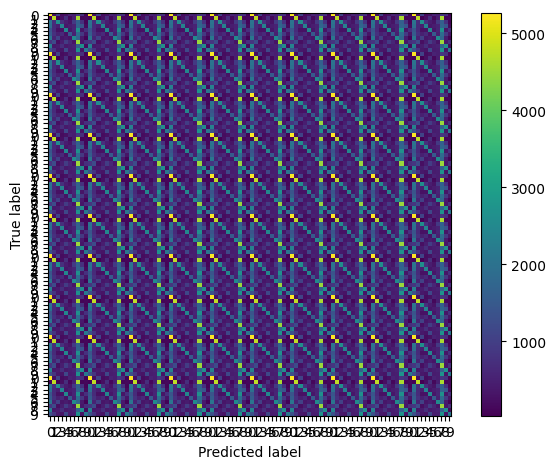

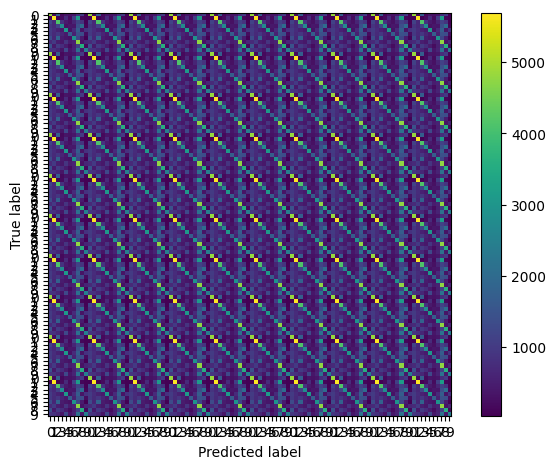

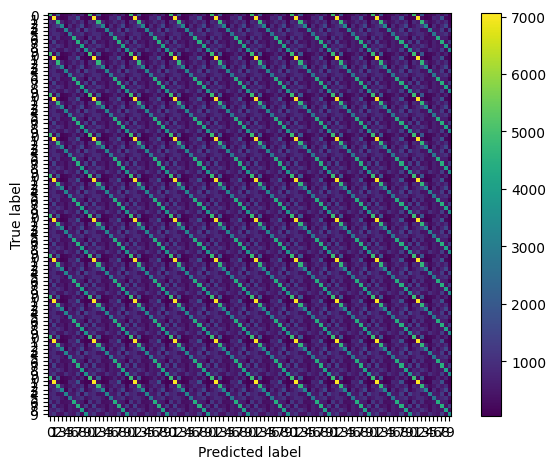

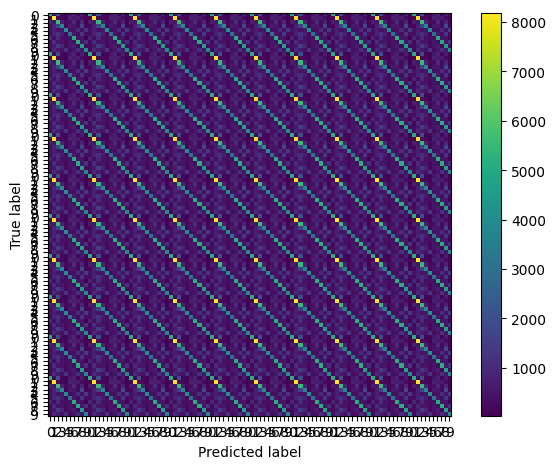

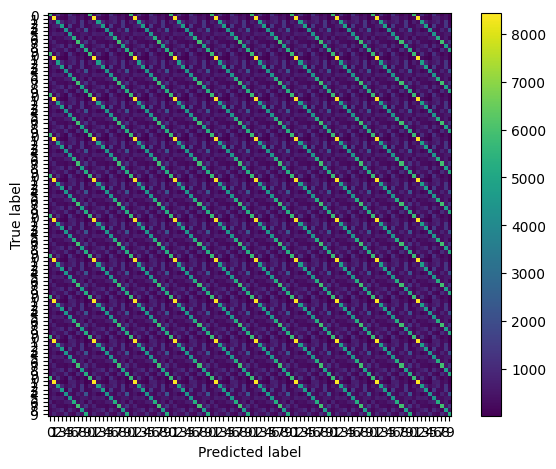

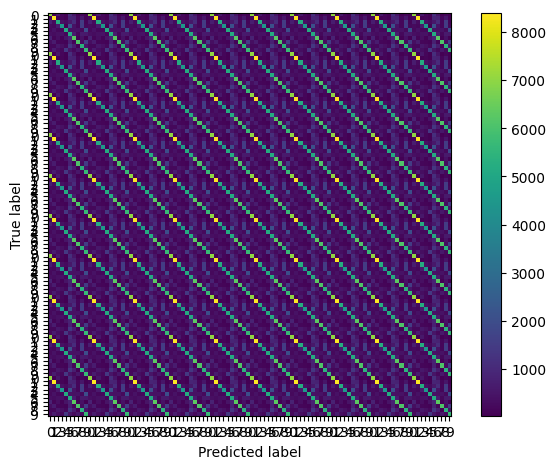

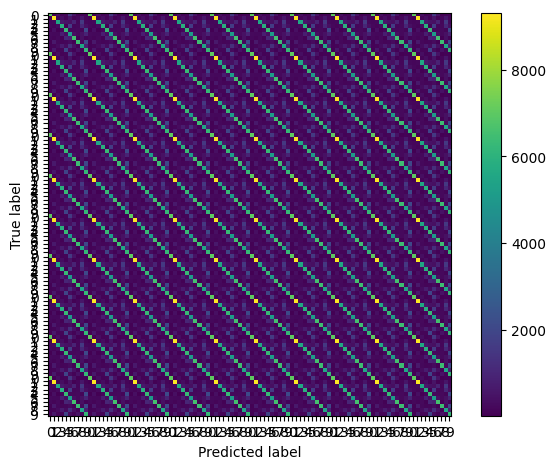

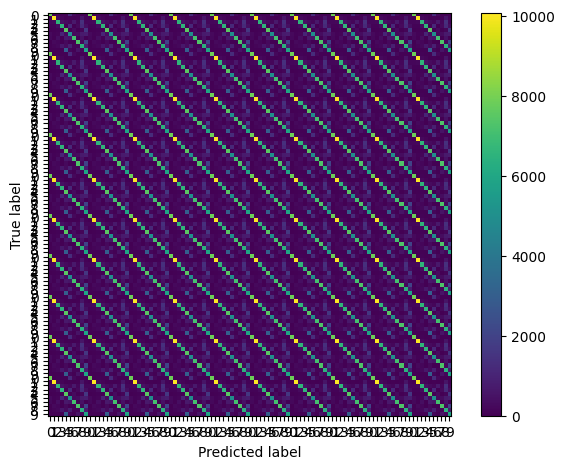

In [19]:
results = list()

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

# Get metrics

In [21]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [22]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [23]:
all_loss_components = strategy.get_store_loss()

In [24]:
weights = model_plugins[0].weights

# Store metrics

In [25]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "all_loss_components": all_loss_components,
    "weights": weights
}, open(SAVED_METRICS_PATH / "cts_v1.pkl", "wb"))

# Load

In [26]:
metrics = pickle.load(open(SAVED_METRICS_PATH / "cts_v1.pkl", "rb"))

# Plot metrics

## Accuracy

In [27]:
fig = px.line(
    pd.DataFrame(metrics["accuracies"]),
    title="Accuracy vs Task",
    labels=dict(index="Task", value="Accuracy"),
    width=800,
    height=600,
    range_y=[0, 1],
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## Forgetting

In [28]:
forgetting_processed = dict()
for i, (key, value) in enumerate(metrics["forgettings"].items()):
    forgetting_processed[key] = [float("nan")] * i + value

fig = px.line(
    pd.DataFrame(forgetting_processed),
    title="Forgetting vs Task",
    labels=dict(index="Task", value="Forgetting"),
    width=800,
    height=600,
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## Losses

In [29]:
fig = px.line(
    pd.DataFrame(metrics["losses"]),
    title="Losses vs Task",
    labels=dict(index="Task", value="Loss"),
    width=800,
    height=600,
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## CPU Usage

In [38]:
fig = px.line(
    metrics["train_cpu_usage"],
    title="CPU Usage vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Time per epoch

In [39]:
fig = px.line(
    metrics["train_time_epoch"],
    title="Time per Epoch vs Epoch",
    labels=dict(index="Epoch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Running time

In [40]:
fig = px.line(
    metrics["train_running_time"],
    title="Running Time vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Training loss

In [41]:
fig = px.line(
    metrics["train_loss_epoch"],
    title="Loss vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## All components losses

In [43]:
fig = px.line(
    metrics["all_loss_components"],
    title="Loss Components vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
    log_y=True,
)
fig.update_xaxes(type="category")
fig.show()

## Weights used

In [36]:
used_weights = list(map(lambda x: sum((abs(x) > 1e-5)).item(), metrics["weights"]))

In [44]:
fig = px.line(
    used_weights,
    title="Used Weights vs Task",
    labels=dict(index="Task", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()